# PycWB Tutorial

## 1. Run your first example

First, we download the example user parameter file

generate injected data for each detector with given parameters in config

In [1]:
user_parameters = """
analysis: "2G"
cfg_search: "r"

optim: False

###### network configuration ######
ifo: ["L1","H1"]
refIFO: "L1"

inRate: 16384
# lags
lagSize: 1
lagStep: 1.
lagOff: 0
lagMax: 0

# superlags
slagSize: 0 # number of super lags (simulation=1) - if slagSize=0 -> Standard Segments
slagMin: 0
slagMax: 0
slagOff: 0

# job
segLen: 1200
segMLS: 600
segTHR: 200
segEdge: 10

# frequency
fLow: 16.
fHigh: 1024.


levelR: 3
l_low: 4 # low frequency resolution level		// std (sthr = 2)
l_high: 10 # high frequency resolution level	// std (sthr = 8)

wdmXTalk: "wdmXTalk/OverlapCatalog16-1024.bin"

healpix: 7

###### cWB production thresholds & regulators ######

bpp: 0.001
subnet: 0.5
subcut: 0.0
netRHO: 5.5
# cedRHO: 5.0
netCC: 0.5
Acore: 1.7
Tgap: 0.2
Fgap: 128.0
delta: 0.5
cfg_gamma: -1.0
LOUD: 300

pattern: 5

iwindow: 30

nSky: 196608

# simulation
# simulation: None
nfactor: 1
"""

with open('user_parameters.yaml', 'w') as fp:
    fp.write(user_parameters)

In [2]:
import os

import pycwb
from pycwb.config import Config
from pycwb.modules.logger import logger_init

if not os.environ.get('HOME_WAT_FILTERS'):
    pyburst_path = os.path.dirname(os.path.abspath(pycwb.__file__))
    os.environ['HOME_WAT_FILTERS'] = f"{os.path.abspath(pyburst_path)}/vendor"

logger_init()

config = Config('./user_parameters.yaml')

Welcome to JupyROOT 6.26/10
Loading wavelet library
Trying to load wavelet library from /usr/local/Cellar/micromamba/2.1.0/envs/pycwb/lib/python3.10/site-packages/lib/wavelet.so


25-04-29 04:58:55 - logger_init - INFO - Logging initialized
25-04-29 04:58:55 - logger_init - INFO - Logging level: INFO
25-04-29 04:58:55 - logger_init - INFO - Logging file: None
25-04-29 04:58:57 - check_MRA_catalog - INFO - Checking MRA catalog
25-04-29 04:58:58 - load_MRA - INFO - Loading catalog of WDM cross-talk coefficients: /usr/local/Cellar/micromamba/2.1.0/envs/pycwb/lib/python3.10/site-packages/pycwb/vendor/wdmXTalk/OverlapCatalog16-1024.bin


In [3]:
from pycwb.modules.read_data import read_from_catalog, read_from_online
from gwpy.timeseries import TimeSeries

import requests
from gwosc.locate import get_urls
t0 = 1242459857.4

data = []
for ifo in config.ifo:
  url = get_urls(ifo, t0, t0)[-1]

  print('Downloading: ' , url)
  fn = os.path.basename(url)
  with open(fn,'wb') as strainfile:
      straindata = requests.get(url)
      strainfile.write(straindata.content)

  strain = TimeSeries.read(fn,format='hdf5.gwosc')
  d = strain.crop(t0-150, t0+150)
  d_resampled = d.resample(2048)
  data.append(d_resampled)

Downloading:  https://gwosc.org/eventapi/json/GWTC-2.1-confident/GW190521_074359/v2/L-L1_GWOSC_4KHZ_R1-1242457810-4096.hdf5
Downloading:  https://gwosc.org/eventapi/json/GWTC-2.1-confident/GW190521_074359/v2/H-H1_GWOSC_4KHZ_R1-1242457810-4096.hdf5


apply data conditioning to the data

25-04-29 05:19:29 - data_conditioning - INFO - Start data conditioning in parallel
25-04-29 05:19:46 - data_conditioning - INFO - -------------------------------------------------------
25-04-29 05:19:46 - data_conditioning - INFO - Data Conditioning Time: 16.15 seconds
25-04-29 05:19:46 - data_conditioning - INFO - -------------------------------------------------------


((<pycwb.types.time_frequency_series.TimeFrequencySeries at 0x15be5f940>,
  <pycwb.types.time_frequency_series.TimeFrequencySeries at 0x15be5f700>),
 (<pycwb.types.time_frequency_series.TimeFrequencySeries at 0x15be5fa60>,
  <pycwb.types.time_frequency_series.TimeFrequencySeries at 0x15be5f880>))

Loading wavelet library
Trying to load wavelet library from /usr/local/Cellar/micromamba/2.1.0/envs/pycwb/lib/python3.10/site-packages/lib/wavelet.so
Loading wavelet library
Trying to load wavelet library from /usr/local/Cellar/micromamba/2.1.0/envs/pycwb/lib/python3.10/site-packages/lib/wavelet.so


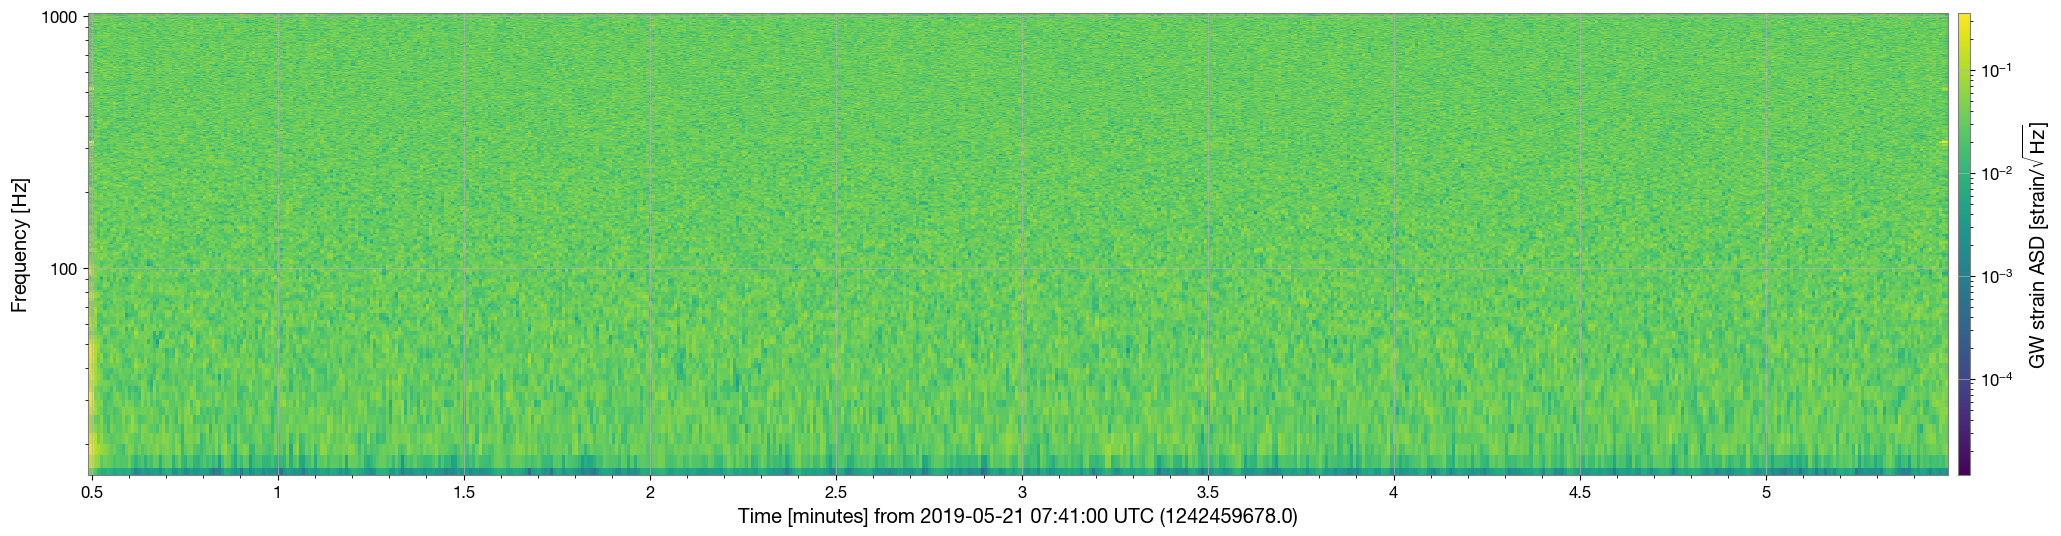

In [4]:
from pycwb.modules.data_conditioning import data_conditioning
from pycwb.modules.plot import plot_spectrogram

strains, nRMS = data_conditioning(config, data)

# plot the spectrogram for L1
plt = plot_spectrogram(strains[0], gwpy_plot=True)
ax = plt.gca()
ax.set_ylim(15,1024)

strains, nRMS

calculate coherence

In [5]:
from pycwb.modules.coherence import coherence

# calculate coherence
fragment_clusters = coherence(config, strains, nRMS)

25-04-29 05:20:15 - coherence - INFO - Start coherence in parallel
25-04-29 05:20:35 - coherence - INFO - ----------------------------------------
25-04-29 05:20:35 - coherence - INFO - Coherence time totally: 20.438101 s
25-04-29 05:20:35 - coherence - INFO - ----------------------------------------


supercluster

In [6]:
from pycwb.modules.super_cluster import supercluster
from pycwb.types.network import Network

network = Network(config, strains, nRMS)

pwc_list = supercluster(config, network, fragment_clusters, strains)

25-04-29 05:21:59 - set_time_shift - INFO - lag step: 1.0
25-04-29 05:21:59 - set_time_shift - INFO - number of time lags: 1
25-04-29 05:22:01 - sparse_table_from_fragment_clusters - INFO - ----------------------------------------
25-04-29 05:22:01 - sparse_table_from_fragment_clusters - INFO - Sparse series time: 1.62 s
25-04-29 05:22:01 - sparse_table_from_fragment_clusters - INFO - ----------------------------------------
25-04-29 05:22:03 - supercluster - INFO - -> Processing lag=0 ...
25-04-29 05:22:03 - supercluster - INFO -    --------------------------------------------------
25-04-29 05:22:03 - supercluster - INFO -     coher clusters|pixels      :     67|982
25-04-29 05:22:03 - supercluster - INFO -     super clusters|pixels      :      7|519
25-04-29 05:22:03 - supercluster - INFO -    defrag clusters|pixels      :      7|519
25-04-29 05:22:03 - supercluster - INFO -    subnet clusters|pixels      :      1|370
25-04-29 05:22:04 - supercluster - INFO - Supercluster done
25-04

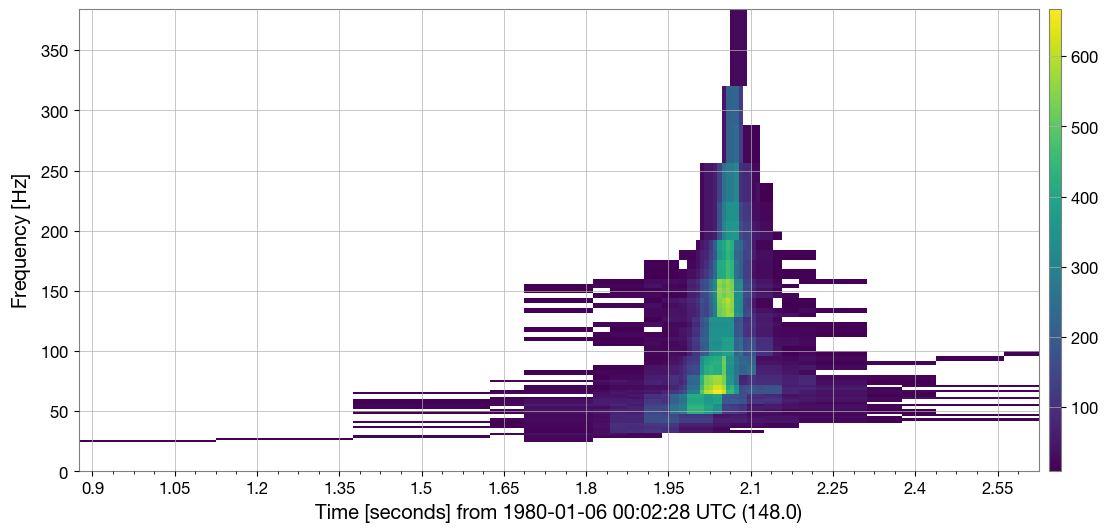

In [7]:
%matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in pwc_list[0].clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("likelihood")

    plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

Likelihood

In [8]:
from pycwb.modules.likelihood import likelihood

events, clusters, skymap_statistics = likelihood(config, network, pwc_list)

25-04-29 05:23:04 - likelihood - INFO - -------------------------------------------------------
25-04-29 05:23:04 - likelihood - INFO - -> Processing 1 clusters in lag=0
25-04-29 05:23:04 - likelihood - INFO -    ----------------------------------------------------
25-04-29 05:23:09 - _likelihood - INFO - Selected core pixels: 1
25-04-29 05:23:09 - _likelihood - INFO -    cluster-id|pixels:     1|370
25-04-29 05:23:09 - _likelihood - INFO - 	 -> SELECTED !!!
25-04-29 05:23:13 - likelihood - INFO - -------------------------------------------------------
25-04-29 05:23:13 - likelihood - INFO - Total events: 1
25-04-29 05:23:13 - likelihood - INFO - Total time: 9.39 s
25-04-29 05:23:13 - likelihood - INFO - -------------------------------------------------------
mchirp_2g : 1 1 4.40e+01 3.201 150.061 0.000 1.038 



plot statistics

/usr/local/Cellar/micromamba/2.1.0/envs/pycwb/lib/python3.10/site-packages/gwpy/plot/plot.py:297: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


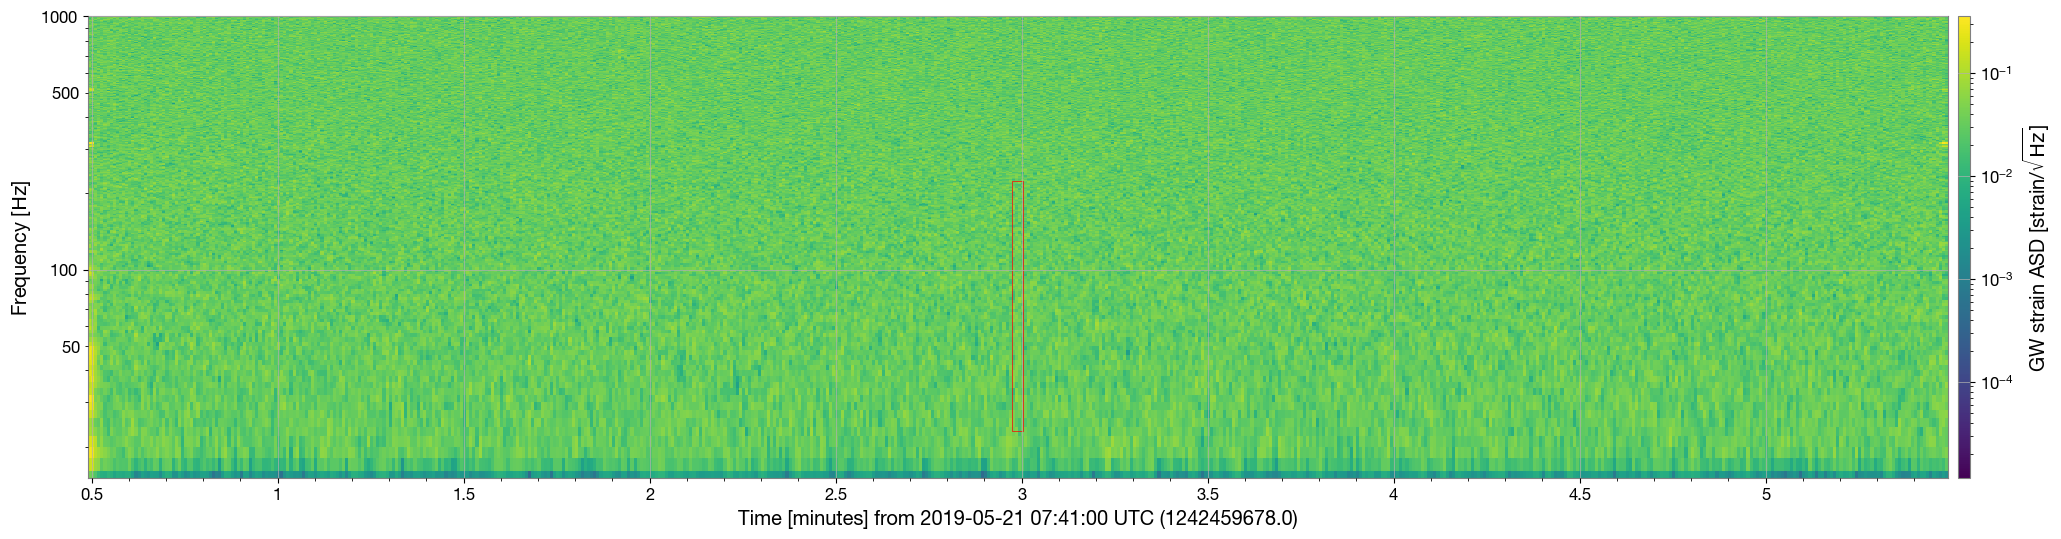

In [9]:
%matplotlib inline
from pycwb.modules.plot import plot_event_on_spectrogram

plt = plot_event_on_spectrogram(strains[0], events)
plt.show()

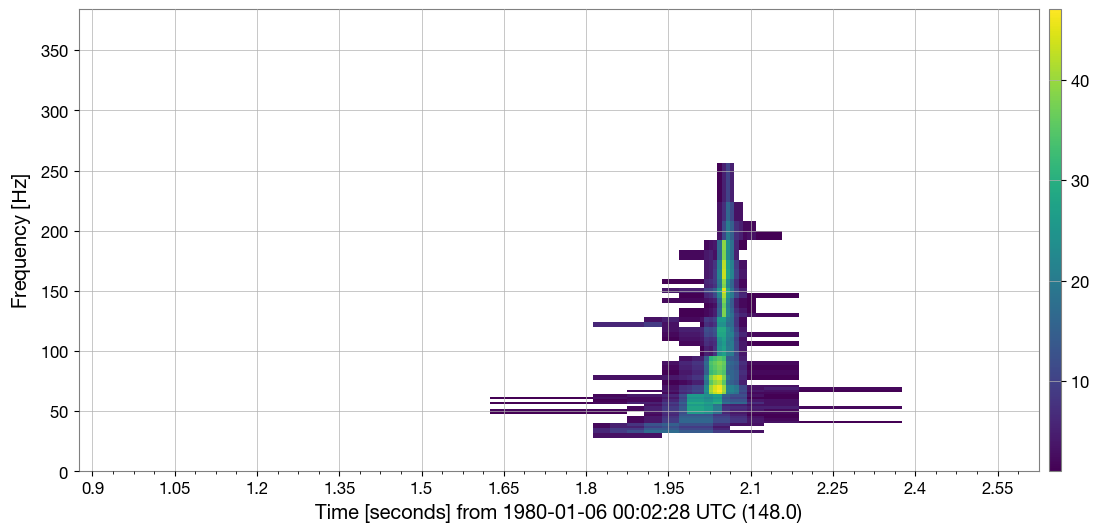

In [10]:
%matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("likelihood")

    plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

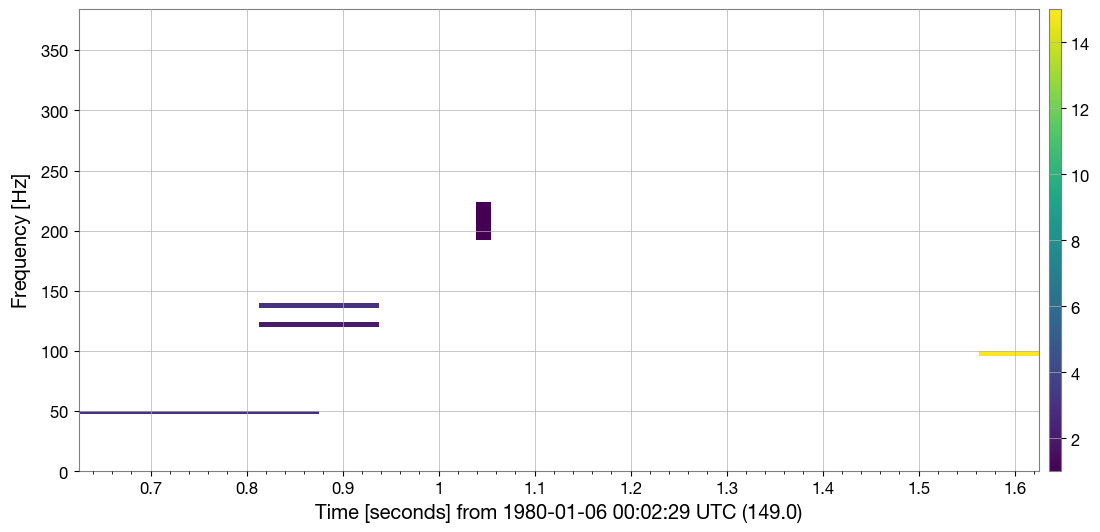

In [11]:
%matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("null")

    plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

(149.0, 150.75)

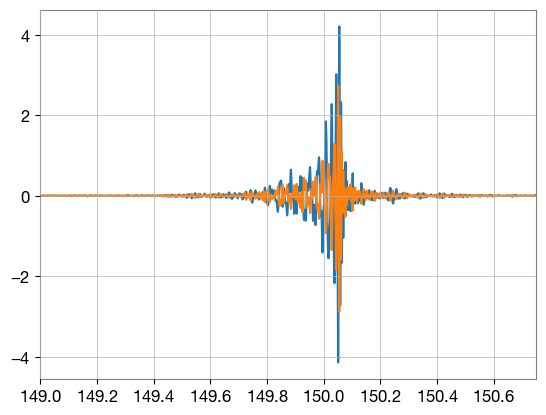

In [12]:
from pycwb.modules.reconstruction import get_network_MRA_wave
from pycwb.modules.plot.waveform import plot_reconstructed_waveforms
from matplotlib import pyplot as plt

event = events[0]
cluster = clusters[0]
reconstructed_waves = get_network_MRA_wave(config, cluster, config.rateANA, config.nIFO, config.TDRate,
                                               'signal', 0, True)
for reconstructed_wave in reconstructed_waves:
  plt.plot(reconstructed_wave.sample_times, reconstructed_wave.data)
plt.xlim((event.left[0], event.left[0] + event.stop[0] - event.start[0]))